In [19]:
# Import
import numpy as np
import torch
import scipy.io
from matplotlib import pyplot as plt
import time
import torcwa
import Materials
import cv2

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
lamb0 = torch.tensor(940.,dtype=geo_dtype,device=device)    # nm
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 1.46**2
silicon_eps = Materials.aSiH.apply(lamb0)**2

# geometry
L = [7648.5*2 , 4041.]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = int(L[0]//4)
torcwa.rcwa_geo.ny = int(L[1]//4)
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000. #????

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()
# layers

In [20]:
def get_order(sim,orders=[0,0],direction='forward',port='transmission',ref_order=[0,0]):
    '''
        Return T_all.

        Parameters
        - orders: selected orders (Recommended shape: Nx2)
        - direction: set the direction of light propagation ('f', 'forward' / 'b', 'backward')
        - port: set the direction of light propagation ('t', 'transmission' / 'r', 'reflection')
        - polarization: set the input and output polarization of light ((output,input) xy-pol: 'xx' / 'yx' / 'xy' / 'yy' , ps-pol: 'pp' / 'sp' / 'ps' / 'ss' )
        - ref_order: set the reference for calculating S-parameters (Recommended shape: Nx2)
        - power_norm: if set as True, the absolute square of S-parameters are corresponds to the ratio of power
        - evanescent: Criteria for judging the evanescent field. If power_norm=True and real(kz_norm)/imag(kz_norm) < evanscent, function returns 0 (default = 1e-3)

        Return
        - T_all (torch.Tensor)
    '''
    txx = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='xx',ref_order=ref_order)
    tyy = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='yy',ref_order=ref_order)
    txy = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='xy',ref_order=ref_order)
    tyx = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='yx',ref_order=ref_order)
    T_all = torch.abs(txx)**2 + torch.abs(tyy)**2 + torch.abs(txy)**2 + torch.abs(tyx)**2
    return T_all

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

def validate(rho):
    harmonic_order = [nn_x, nn_y]

    sim = torcwa.rcwa(freq=1/lamb0,order=harmonic_order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()

    T_hex1 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-12,13,2) for yorder in range(-2,3,2)]
    T_hex2 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-11,12,2) for yorder in range(-3,4,2)]
    T_hex = torch.cat([*T_hex1, *T_hex2])

    T_all = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder, yorder in zip(exist_yorder, exist_xorder)]
    T_all = torch.cat(T_all)
    # Calculate the minimum and maximum of the concatenated tensor
    min_T = torch.min(T_hex)
    max_T = torch.max(T_hex)
    efficiency = torch.sum(T_hex) / torch.sum(T_all)
    # Compute the uniformity value
    uniformity = min_T / max_T
    print("===> Avg. efficiency: {:.2f} %".format(efficiency*100))
    print("===> Avg. uniformity: {:.2f} %".format(uniformity*100))
    T_grid = torch.zeros(nn_x, nn_y)
    ylabel_order = [str(i) for i in range(-nn_x//2+1,nn_x//2+1)]
    xlabel_order = [str(i) for i in range(-nn_y//2+1,nn_y//2+1)]
    for i in range(-nn_x//2+1,nn_x//2+1):
        for j in range(-nn_y//2+1,nn_y//2+1):
            T_grid[i-(-nn_x//2+1)][j-(-nn_y//2+1)] = get_order(sim,orders=[i,j],direction='forward',port='transmission',ref_order=[0,0])
    T_grid = T_grid.detach().cpu().numpy()
    T_normalized = T_grid / torch.sum(torch.tensor(T_all)).detach().cpu().numpy()
    T_hex_np = T_hex.detach().cpu().numpy()
    N = T_hex_np.size
    # x 軸座標
    x = np.arange(1, N+1)
    # 畫 bar 圖
    plt.bar(x, T_hex_np)
    # 設定 x 軸和 y 軸標籤
    plt.xlabel('Index')
    plt.ylabel('Value')
    # 顯示圖形
    plt.show()
    # Create the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(T_normalized)
    plt.xticks(np.arange(len(xlabel_order)), labels=xlabel_order)
    plt.yticks(np.arange(len(ylabel_order)), labels=ylabel_order)
    plt.show()

harmonic_x=45
harmonic_y=19
===> Avg. efficiency: 90.73 %
===> Avg. uniformity: 18.14 %


C:\Users\CYY\AppData\Local\Temp\ipykernel_26332\292923067.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_normalized = T_grid / torch.sum(torch.tensor(T_all)).detach().cpu().numpy()


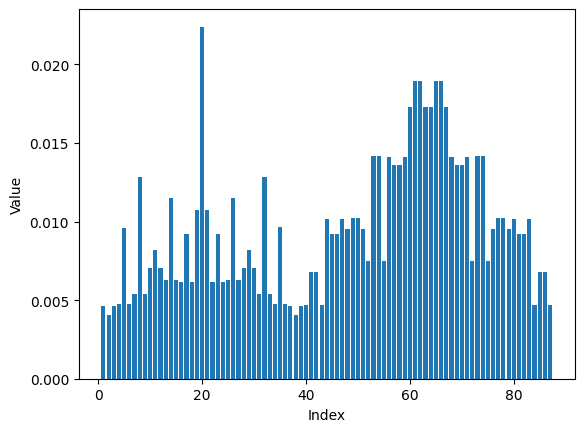

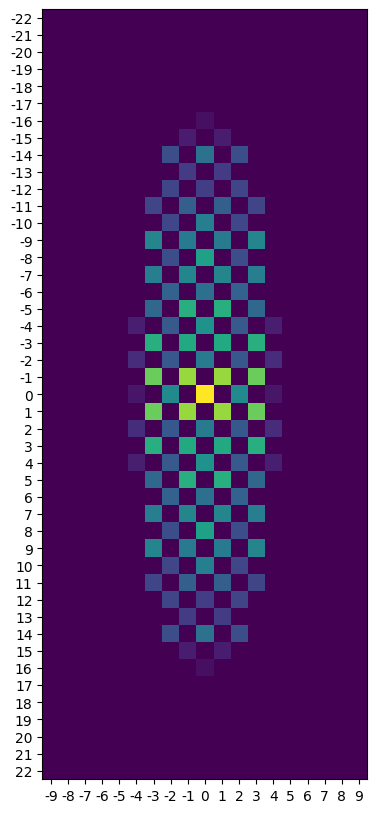

Elapsed time: 713 s


In [21]:
start_time = time.time()
nn_x = 45
nn_y = 19
layer0_thickness = 235.
image_path = 'check_point_hex2.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (torcwa.rcwa_geo.ny, torcwa.rcwa_geo.nx))/ 255.0 
# Convert image to tensor
rho = torch.tensor(image_resized, dtype=geo_dtype, device=device)
# order
lamb0 = torch.tensor(940.,dtype=geo_dtype,device=device)    # nm
n = np.arange(-100, 101)
m = np.arange(-100, 101)
yorder, xorder = np.meshgrid(m, n)
kx = xorder * lamb0.cpu().numpy()/L[1]
ky = yorder * lamb0.cpu().numpy()/L[0]
exist_xorder = xorder[np.where((kx**2 + ky**2) <= 1)]
exist_yorder = yorder[np.where((kx**2 + ky**2) <= 1)]
print(f'harmonic_x={nn_x}')
print(f'harmonic_y={nn_y}')
validate(rho)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time:',str(int(elapsed_time))+' s')